In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import torchvision
import torchaudio
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.datapipes.iter import FileLister
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import os
import librosa
from sklearn.model_selection import StratifiedKFold, cross_val_score
import time
import copy
from tqdm import tqdm
from math import ceil
import random

In [2]:
train_folder = "../input/birdclef-2022/train_audio"
meta_file_path = "../input/birdclef-2022/train_metadata.csv"

In [3]:
meta_data = pd.read_csv(meta_file_path)

In [4]:
classes = list(meta_data['primary_label'].unique())
print(len(classes))
print(classes)

152
['afrsil1', 'akekee', 'akepa1', 'akiapo', 'akikik', 'amewig', 'aniani', 'apapan', 'arcter', 'barpet', 'bcnher', 'belkin1', 'bkbplo', 'bknsti', 'bkwpet', 'blkfra', 'blknod', 'bongul', 'brant', 'brnboo', 'brnnod', 'brnowl', 'brtcur', 'bubsan', 'buffle', 'bulpet', 'burpar', 'buwtea', 'cacgoo1', 'calqua', 'cangoo', 'canvas', 'caster1', 'categr', 'chbsan', 'chemun', 'chukar', 'cintea', 'comgal1', 'commyn', 'compea', 'comsan', 'comwax', 'coopet', 'crehon', 'dunlin', 'elepai', 'ercfra', 'eurwig', 'fragul', 'gadwal', 'gamqua', 'glwgul', 'gnwtea', 'golphe', 'grbher3', 'grefri', 'gresca', 'gryfra', 'gwfgoo', 'hawama', 'hawcoo', 'hawcre', 'hawgoo', 'hawhaw', 'hawpet1', 'hoomer', 'houfin', 'houspa', 'hudgod', 'iiwi', 'incter1', 'jabwar', 'japqua', 'kalphe', 'kauama', 'laugul', 'layalb', 'lcspet', 'leasan', 'leater1', 'lessca', 'lesyel', 'lobdow', 'lotjae', 'madpet', 'magpet1', 'mallar3', 'masboo', 'mauala', 'maupar', 'merlin', 'mitpar', 'moudov', 'norcar', 'norhar2', 'normoc', 'norpin', 'norsh

In [5]:
SAMPLE_RATE = 44100
NUM_SAMPLES = SAMPLE_RATE*5
N_MELS = 431
HOP_LENGTH = 512
N_FFT = 4096
WINDOW = 1764
BATCH_SIZE = 64
EPOCHS = 3
LEARNING_RATE = 0.0001
WORKERS = 0
NUM_CLASSES = 152
NUM_FOLDS = 10

NEED_MORE = 50
NUM_AUGS = 4

MIN_NOISE = 0.1
MAX_NOISE = 0.4
MIN_PITCH_SCALE = -2
MAX_PITCH_SCALE = 2
MIN_GAIN = 1
MAX_GAIN = 1.5

IMAGE_RESIZE = 215

In [6]:
aug_num_bird_samples = []
classes_need_augmentation = []
for class_name in classes:
    num = (meta_data.primary_label == class_name).sum()
    if num < NEED_MORE:
        classes_need_augmentation.append(class_name)
        aug_num_bird_samples.append(num)

In [7]:
print(classes_need_augmentation)

['afrsil1', 'akekee', 'akepa1', 'akiapo', 'akikik', 'aniani', 'apapan', 'barpet', 'bkwpet', 'blkfra', 'blknod', 'brnboo', 'brnnod', 'brtcur', 'bubsan', 'buffle', 'bulpet', 'burpar', 'cacgoo1', 'canvas', 'chbsan', 'chemun', 'chukar', 'cintea', 'coopet', 'crehon', 'elepai', 'ercfra', 'fragul', 'glwgul', 'golphe', 'grefri', 'gresca', 'gryfra', 'hawama', 'hawcoo', 'hawcre', 'hawgoo', 'hawhaw', 'hawpet1', 'hoomer', 'hudgod', 'iiwi', 'incter1', 'japqua', 'kalphe', 'kauama', 'layalb', 'lcspet', 'lessca', 'lotjae', 'madpet', 'magpet1', 'masboo', 'mauala', 'maupar', 'norhar2', 'oahama', 'omao', 'palila', 'peflov', 'pomjae', 'puaioh', 'reccar', 'redava', 'redpha1', 'refboo', 'rempar', 'rettro', 'rinduc', 'ruff', 'shtsan', 'sooshe', 'sooter1', 'sopsku1', 'wantat1', 'wessan', 'wetshe', 'whfibi', 'whiter', 'whttro', 'yebcar']


In [8]:
print(len(aug_num_bird_samples))
print(len(classes_need_augmentation))

82
82


In [9]:
!nvidia-smi

Mon Aug 15 20:02:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
class BirdDataset(Dataset):
    def __init__(self, train_folder, transformation, augmentations, sample_rate, num_samples, device):
        super().__init__()
        self.device = device
        self.train_files_list = []#list(FileLister(root=train_folder, recursive=True))
        self.transformation = transformation
        self.augmentations = augmentations
        self.sample_rate = sample_rate
        self.num_samples = num_samples
        self._downsample()
        self._add_filenames_for_generation()
        
    def _downsample(self):
        for _, class_name in enumerate(classes):
            class_train_files = list(FileLister(root=train_folder+'/'+class_name))
            if len(class_train_files) > NEED_MORE:
                random.shuffle(list(class_train_files))
                for _, f_name in enumerate(class_train_files[: NEED_MORE]):
                    self.train_files_list.append(f_name)
            else:
                for _, f_name in enumerate(class_train_files):
                    self.train_files_list.append(f_name)
                
    
    def _add_filenames_for_generation(self):
        # loop by classes need more data
        for idx, class_name in enumerate(classes_need_augmentation):
            #Get number of files to be generated per original files
            num_orig_files = aug_num_bird_samples[idx]
            num_gen_files = NEED_MORE - num_orig_files
            num_gen_files_per_orig = ceil( num_gen_files/num_orig_files ) 
            
            class_train_files = list(FileLister(root=train_folder+'/'+class_name))
            #Loop by original file name and add new filename and corresponding classname
            for count in range(num_orig_files):
                for i in range(num_gen_files_per_orig):
                    new_filename = class_train_files[count] + 'augment'
                    self.train_files_list.append(new_filename)
        
    def __len__(self):
        self.total_train_file = len(self.train_files_list)
        return self.total_train_file
        
    def list_all_files(self):
        return list(self.train_files_list)
    
    def _resample(self, signal, sr):
        if sr != self.sample_rate: 
            resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
            signal = resampler(signal)
        return signal
    
    def _mix_channels(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
    
    def _right_padding(self,signal):
        if signal.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - signal.shape[1]
            last_dim_pad = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_pad)
        return signal
        
    def _crop(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal
    
    def _aug_white_noise(self,signal):
        scale = np.random.uniform(MIN_NOISE, MAX_NOISE)
        noise = np.random.normal(0, signal.std(), signal.size)
        aug_sig = signal + noise*scale
        return aug_sig
        
    def __getitem__(self,index):
        filename = self.train_files_list[index]
        temp = filename.split(os.sep)
        label = temp[-2]
        if_aug = False
        if 'augment' in filename:
            if_aug = True
            filename = filename[:-7]
        label = classes.index(label)
        #label = label.to(self.device)
        signal, sr = torchaudio.load(filename)
        signal = self._resample(signal, sr)
        signal = signal.to(self.device)
        signal = self._mix_channels(signal)
        signal = self._right_padding(signal)
        signal = self._crop(signal)
        if if_aug == True:
            #signal = self._aug_white_noise(signal)
            signal = self.augmentations(signal)
        signal = self.transformation(signal)
        signal = torch.stack([signal[0],signal[0],signal[0]])
        return signal,label

In [12]:
pitch_scale = np.random.randint(MIN_PITCH_SCALE, MAX_PITCH_SCALE)
pitch_scaler = torchaudio.transforms.PitchShift(sample_rate= SAMPLE_RATE, n_steps=pitch_scale)

gain_scale = np.random.uniform(MIN_GAIN, MAX_GAIN)
gain_scaler = torchaudio.transforms.Vol(gain=gain_scale)

aug_transfms = [pitch_scaler.to(device),gain_scaler.to(device)]

augmentations = transforms.Compose(
[
    transforms.RandomChoice(aug_transfms)
])

In [13]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)

mean = np.array([0.5])
std = np.array([0.5])
data_transforms = transforms.Compose(
[
    mel_spectrogram.to(device),
    transforms.ToPILImage(),
    transforms.Resize([IMAGE_RESIZE, IMAGE_RESIZE]).to(device),
    transforms.ToTensor(),
    transforms.Normalize(mean, std).to(device)
])

In [14]:
bird_cleff_ds = BirdDataset(train_folder, data_transforms, augmentations, SAMPLE_RATE, NUM_SAMPLES, device)

In [15]:
bird_cleff_ds.__len__()

8602

In [16]:
train_size = int(0.8 * bird_cleff_ds.__len__())
val_size = bird_cleff_ds.__len__() - train_size
trainset, valset = torch.utils.data.random_split(bird_cleff_ds, [train_size, val_size])

In [17]:
len(trainset), len(valset)

(6881, 1721)

In [18]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
valloader  = DataLoader(valset, batch_size=BATCH_SIZE, num_workers=WORKERS)

In [19]:
len(trainloader), len(valloader)

(108, 27)

In [20]:
dataiter = iter(trainloader)
sample = dataiter.next()
s,l = sample

In [21]:
s.shape

torch.Size([64, 3, 215, 215])

In [22]:
def plot_spectrogram(spec, xmax=None):
    fig, axs = plt.subplots(1, 1, figsize=(10,4))
    axs.set_title("Mel-Spectrogram")
    axs.set_ylabel("mel-freq")
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect="auto")
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

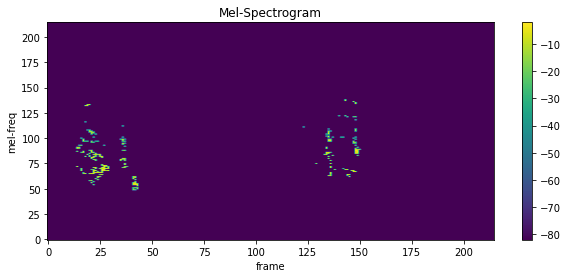

In [23]:
plot_spectrogram(s[14][0].cpu())

In [24]:
del dataiter

In [25]:
del s
del l

In [20]:

def get_model():
    model = models.resnet50(pretrained=True)
    num_ftrs_last_layer = model.fc.in_features
    
    model.fc = nn.Linear(num_ftrs_last_layer, NUM_CLASSES)
    return model

In [21]:
#from torch.torchsummary import summary

model = get_model()
model = model.to(device)
print(model)
#summary(model, input_size=(64, 3, 215, 215))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
SAVED_MODEL_PATH = '../input/saved-weights/bird_cleff_fine_tuned_model (8).pt'
model.load_state_dict(torch.load(SAVED_MODEL_PATH))

<All keys matched successfully>

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#lr_step_sched = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [25]:
# Train and eval funcs:

def train_func(trainloader, model, optimizer, criterion):
    
    total_loss = 0.0
    model.train()
    
    #TQDM progress bar
    loop = tqdm(trainloader, total=len(trainloader), leave=False)
    
    for mel_specs, labels in loop:
        mel_specs = mel_specs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(mel_specs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss = loss.item())
  
    return total_loss/ len(trainloader)

def eval_func(valloader, model, criterion):
    total_loss = 0.0
    model.eval()
    
    #TQDM progress bar
    loop = tqdm(valloader, total=len(valloader), leave=False)
    

    for mel_specs, labels in loop:
        mel_specs = mel_specs.to(device)
        labels = labels.to(device)

        logits = model(mel_specs)
        loss = criterion(logits, labels)

        total_loss += loss.item()
        loop.set_postfix(loss = loss.item())

    return total_loss/ len(valloader)

In [26]:
#Training

best_val_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_func( trainloader, model, optimizer, criterion)
  val_loss = eval_func(valloader, model, criterion)

  if val_loss < best_val_loss:
    torch.save(model.state_dict(), 'bird_cleff_fine_tuned_model.pt')
    print("Model saved!")
    best_val_loss = val_loss

  print(f"Epoch={i+1}, train_loss= {train_loss}, val_loss={val_loss}")

Model saved!
Epoch=1, train_loss= 0.1405510309462746, val_loss=0.11977569220794572


Model saved!
Epoch=2, train_loss= 0.0644875579962024, val_loss=0.11521359381300432


Epoch=3, train_loss= 0.044480186257580365, val_loss=0.11972362182482525


In [27]:
from sklearn.metrics import confusion_matrix, classification_report

In [28]:
model.eval()
for mel_specs, truth_labels in valloader:
    mel_specs = mel_specs.to(device)
    truth_labels = truth_labels.to(device)
    logits = model(mel_specs)
    preds = torch.argmax(logits, dim= 1)

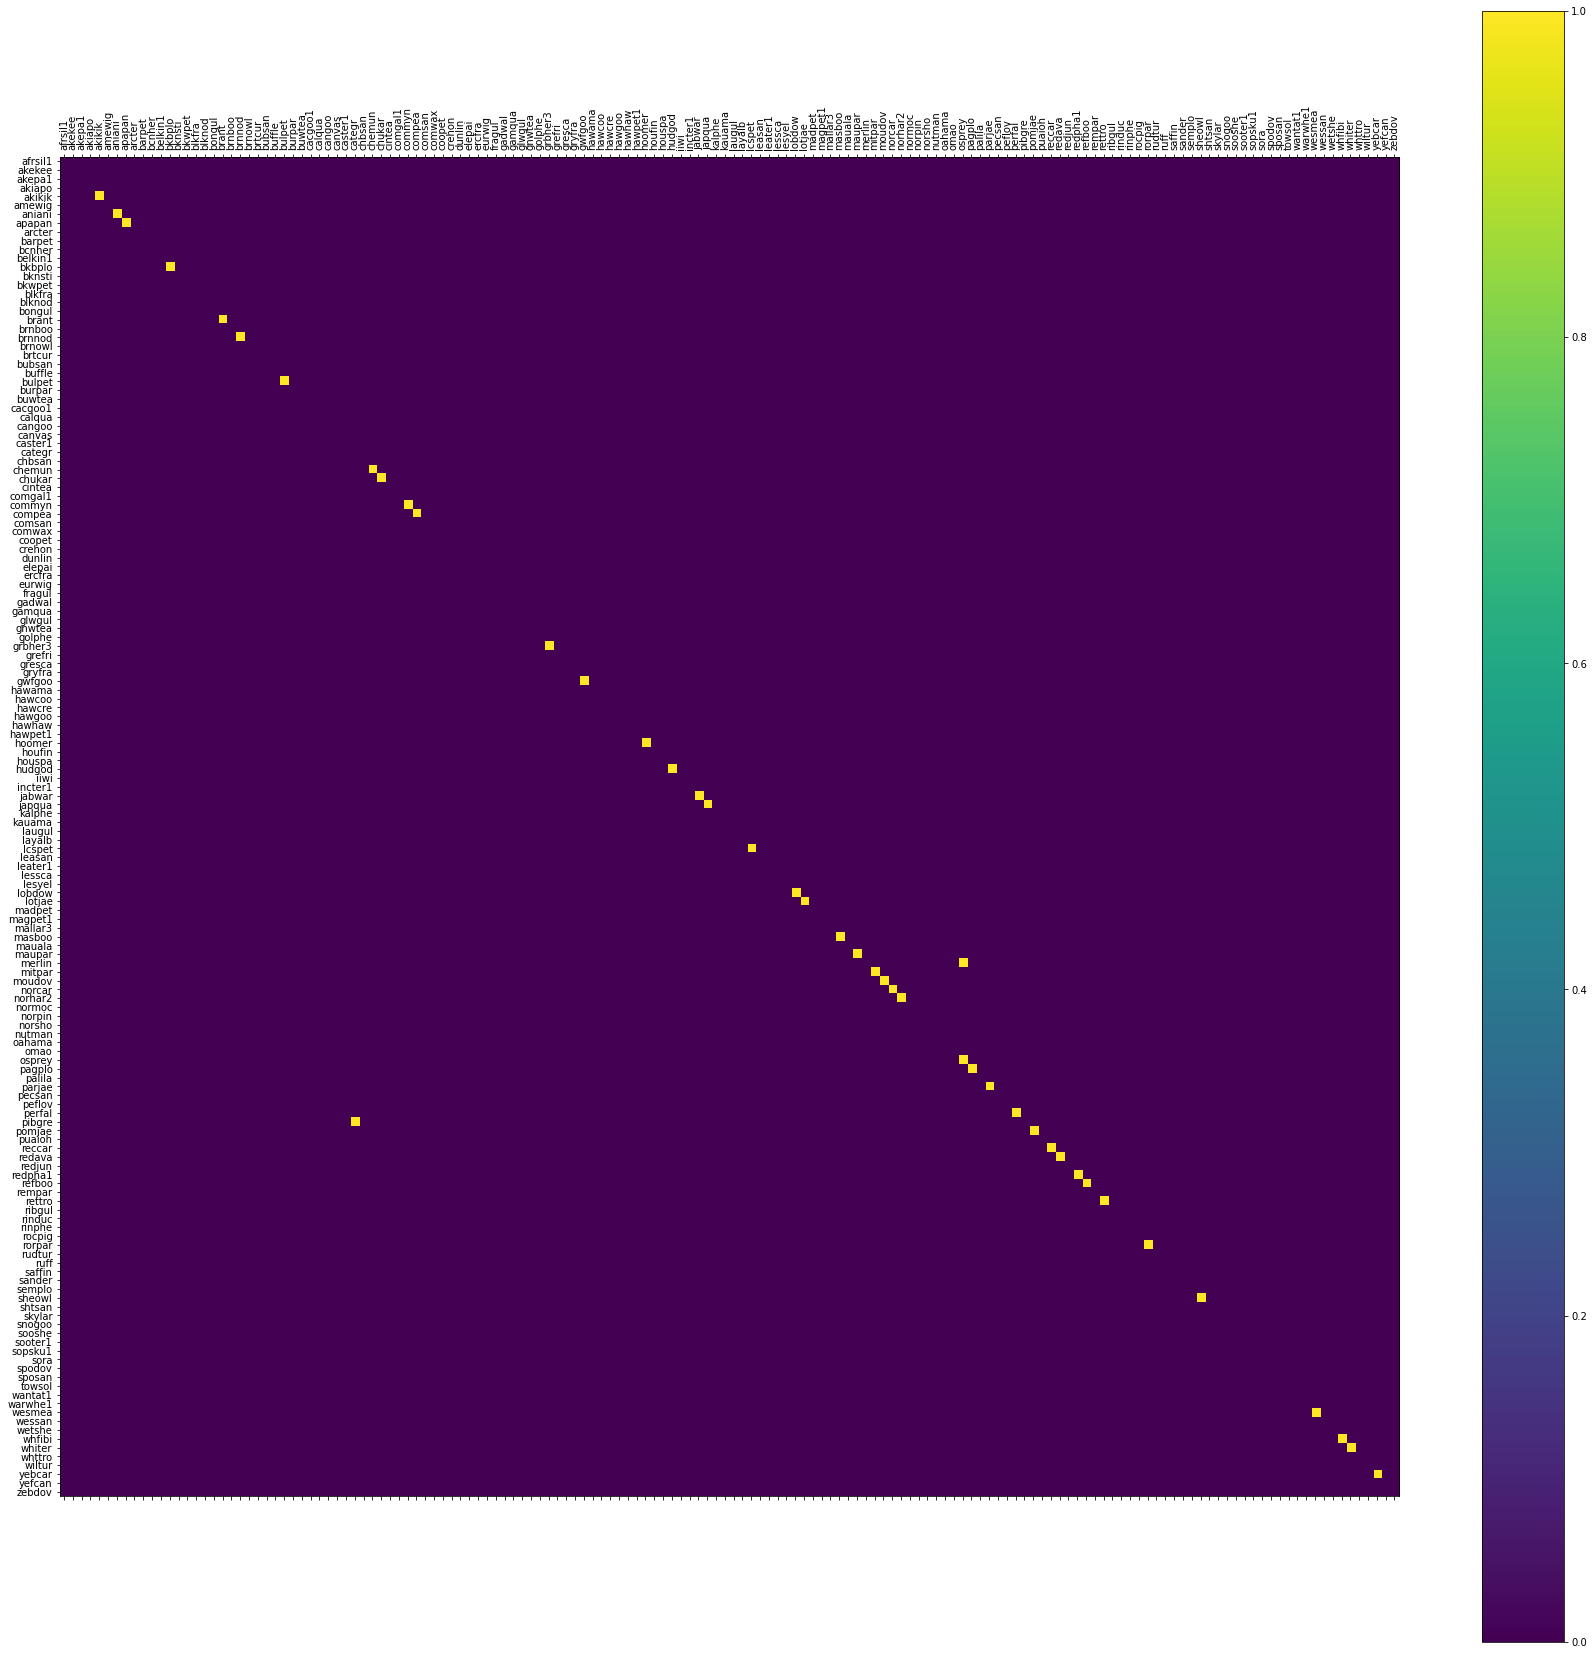

In [32]:
cm = confusion_matrix(truth_labels.cpu(), preds.cpu(), labels=range(152), normalize= 'true')
plt.figure(figsize=(30, 30))
sp = plt.subplot(1, 1, 1)
ctx = sp.matshow(cm)
plt.xticks(list(range(0, 152)), labels=classes, rotation= 90)
plt.yticks(list(range(0, 152)), labels=classes)
plt.colorbar(ctx)
plt.show()

In [33]:
print(cm)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [34]:
print(classification_report(truth_labels.cpu(), preds.cpu()))

              precision    recall  f1-score   support

           4       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
          12       1.00      1.00      1.00         2
          18       1.00      1.00      1.00         1
          20       1.00      1.00      1.00         1
          25       1.00      1.00      1.00         2
          33       0.00      0.00      0.00         0
          35       1.00      1.00      1.00         1
          36       1.00      1.00      1.00         1
          39       1.00      1.00      1.00         1
          40       1.00      1.00      1.00         1
          55       1.00      1.00      1.00         1
          59       1.00      1.00      1.00         2
          66       1.00      1.00      1.00         2
          69       1.00      1.00      1.00         1
          72       1.00      1.00      1.00         2
          73       1.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1